In [16]:
import pickle
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb

import matplotlib.pyplot as plt

#!pip install unhcrpyplotstyle

In [17]:
target_emissions_statistics = {
    'total_scope1': {
        'num_observations': 13956,
        'mean': 3.37,
        'median': 0.08,
        'std_deviation': 13.59,
        'jqbera_p_value': 0.001
    },
    'total_scope2': {
        'num_observations': 13956,
        'mean': 0.79,
        'median': 0.14,
        'std_deviation': 3.42,
        'jqbera_p_value': 0.001
    },
    'total_scope3': {
        'num_observations': 8260,
        'mean': 13.33,
        'median': 0.05,
        'std_deviation': 65.60,
        'jqbera_p_value': 0.001
    },
    'total_emissions': {
        'num_observations': 13956,
        'mean': 4.16,
        'median': 0.30,
        'std_deviation': 14.88,
        'jqbera_p_value': 0.001
    }
}

target_feature_statistics = {
    'revenue': {
        'num_observations': 13956,
        'mean': 16988.08,
        'median': 5891.07,
        'std_deviation': 34207.83,
        'jqbera_p_value': 0.001
    },
    'employees': {
        'num_observations': 12821,
        'mean': 42745.57,
        'median': 16702,
        'std_deviation': 83232,
        'jqbera_p_value': 0.001
    },
    'total_assets': {
        'num_observations': 13956,
        'mean': 47182.20,
        'median': 10390.12,
        'std_deviation': 111607.80,
        'jqbera_p_value': 0.001
    },
    'net_property': {
        'num_observations': 13843,
        'mean': 7213.24,
        'median': 1806,
        'std_deviation': 17946.58,
        'jqbera_p_value': 0.001
    },
    'intangible_assets': {
        'num_observations': 13956,
        'mean': 2635.44,
        'median': 401.07,
        'std_deviation': 7623.83,
        'jqbera_p_value': 0.001
    },
    'leverage': {
        'num_observations': 13956,
        'mean': 20.84,
        'median': 18.07,
        'std_deviation': 19.32,
        'jqbera_p_value': 0.001
    },
    'capital_expenditure': {
        'num_observations': 13956,
        'mean': 64.22,
        'median': 27.20,
        'std_deviation': 153.47,
        'jqbera_p_value': 0.001
    },
    'gross_margin': {
        'num_observations': 13956,
        'mean': 49.90,
        'median': 43.69,
        'std_deviation': 29.49,
        'jqbera_p_value': 0.001
    },
    'fuel_intensity': {
        'num_observations': 13956,
        'mean': 429.18,
        'median': 456,
        'std_deviation': 223.45,
        'jqbera_p_value': 0.020
    }
}

In [18]:
def generate_historical_data(num_years=5, num_companies=100, seed=42):
    np.random.seed(seed)
    years = np.tile(np.arange(2023 - num_years, 2023), num_companies)
    company_ids = np.repeat(np.arange(num_companies), num_years)
    data = {
        'company_id': company_ids,
        'year': years,
        'revenue': np.random.normal(1e6, 2e5, num_years * num_companies),
        'stationary_combustion': np.random.normal(120, 20, num_years * num_companies),
        'mobile_sources': np.random.normal(80, 10, num_years * num_companies),
        'refrigeration': np.random.normal(30, 6, num_years * num_companies),
        'fire_suppression': np.random.normal(20, 4, num_years * num_companies),
        'purchased_gases': np.random.normal(40, 8, num_years * num_companies),
        'electricity': np.random.normal(500, 200, num_years * num_companies),
        'steam': np.random.normal(200, 100, num_years * num_companies),
        'waste': np.random.normal(60, 12, num_years * num_companies),
        'business_travel': np.random.normal(80, 16, num_years * num_companies),
        'commuting': np.random.normal(70, 14, num_years * num_companies),
        'upstream_distribution': np.random.normal(90, 18, num_years * num_companies)
    }
    return pd.DataFrame(data)


# def train_gradboost_model(df, feature_col, target_cols):
#     models = {}
#     X = df[[feature_col]].values
    
#     for target_col in target_cols:
#         y = df[target_col].values
#         model = GradientBoostingRegressor(n_estimators=100, random_state=42)
#         model.fit(X, y)
#         models[target_col] = model
    
#     return models


def train_xgb_models(df, feature_col, target_cols, scope):
    if scope == 'Scope 1':
        scope_pathname = 'scope1'
    elif scope == 'Scope 2':
        scope_pathname = 'scope2'
    else:
        scope_pathname = 'total_emissions'
    path = f"models/XGB_{scope_pathname}_model.p"
    fitted_models = {}
    X = df[feature_col].values
    
    for target_col in target_cols:
        y = df[target_col].values
        loaded_model = pickle.load(open(path,"rb"))
        loaded_model.fit(X, y)
        fitted_models[target_col] = loaded_model
    
    return fitted_models


def forecast_emissions(models, last_year_revenue, num_years_forecast=5):
    future_revenue = np.array([last_year_revenue * (1 + 0.05 * i) for i in range(num_years_forecast)])  # Assume 5% annual growth in revenue
    future_X = future_revenue.reshape(-1, 1)
    
    emissions_data = {}
    for emission_type, model in models.items():
        predicted_emissions = model.predict(future_X)
        emissions_data[emission_type] = predicted_emissions
    
    return pd.DataFrame(emissions_data, index=np.arange(2023, 2023 + num_years_forecast))


def plot_scope_forecast(df, scope):
    x = df.index
    plt.style.use(['unhcrpyplotstyle', 'area'])
    fig, ax = plt.subplots()
    if len(df.columns) <= 4:
        num_cols = len(df.columns)
    else:
        num_cols = np.ceil(len(df.columns)/2).astype(int)

    ax.stackplot(x, *[df[col] for col in df.columns], labels=df.columns.tolist(), alpha=0.8)
    
    ax.legend(loc=(0,1.05), ncol=num_cols)
    ax.set_title(f'Forecast of {scope} Emissions for the Next 5 Years', pad=50)
    ax.set_ylabel('Emissions (MT CO2e)')

    yl = plt.ylim(0,900)

    plt.xticks(x, x)
    
    plt.annotate('Forecast based on Gradient Boosting Model', (0,0), (0, -40),
                 xycoords='axes fraction', textcoords='offset points',
                 va='top', fontsize=9, color='#666666')
    fig.tight_layout()
    plt.show()


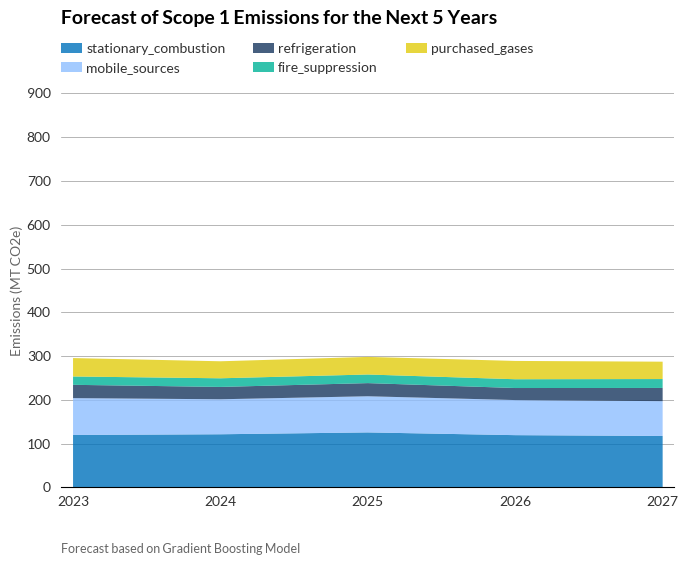

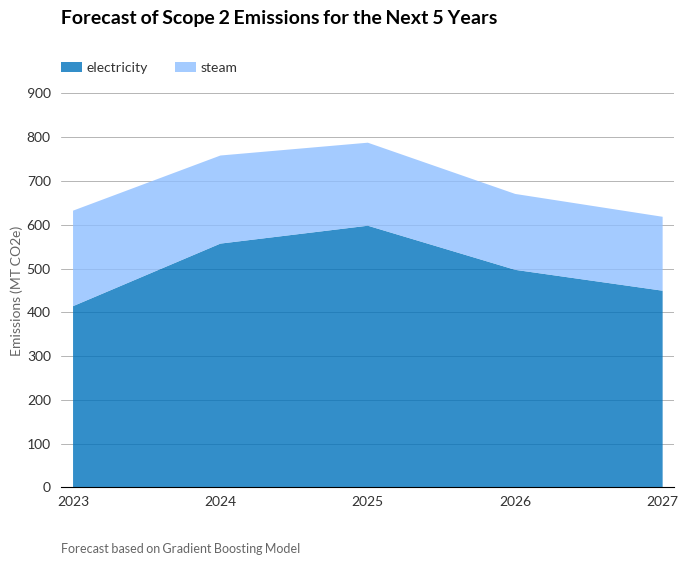

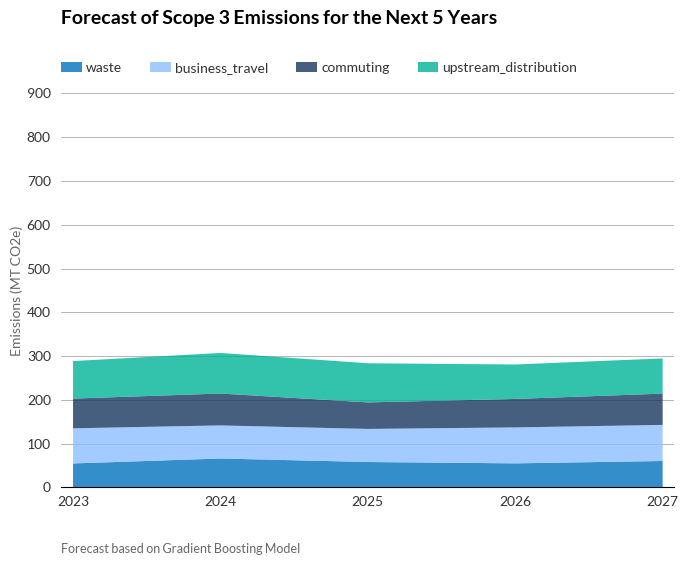

In [20]:
historical_data = generate_historical_data()

# randomly generate 1-year company data for example
new_company_revenue = np.random.normal(1e6, 1e5, 1)[0]

variables_dict = {
    'Scope 1': ['stationary_combustion', 'mobile_sources', 'refrigeration', 'fire_suppression', 'purchased_gases'],
    'Scope 2': ['electricity', 'steam'], 
    'Scope 3': ['waste', 'business_travel', 'commuting', 'upstream_distribution']
}

for scope, emissions in variables_dict.items():
    models = train_xgb_models(df=historical_data, feature_col=['revenue'], target_cols=emissions, scope=scope)
    emissions_forecast = forecast_emissions(models, new_company_revenue)
    plot_scope_forecast(emissions_forecast, scope)